# ARM Quantitative Group project - Autoscout24, Audi A4

Deadline: 12.01.2025, 23.59 Uhr

Unsere Gedanken: Besteht eine Abhängigkeit zwischen dem Antrieb (Allrad, Vorderradantrieb) und dem Preis.

## Libraries and settings

In [219]:
# Libraries
import os
import sqlite3
import fnmatch
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import chi2
from scipy.stats import chi2_contingency
import pylab as py




# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Show current working directory
print(os.getcwd())


# Function to close a sqlite db-connection
def check_conn(conn):
     try:
        conn.cursor()
        return True
     except Exception as ex:
        return False

# Get current working directory
print(os.getcwd())

/workspaces/project_arm_autoscout_audia1
/workspaces/project_arm_autoscout_audia1


## Import data

In [220]:
## Read data
df = pd.read_csv("./data/as24_a4.csv", sep=",")
df.head()

# Show column names from df
print(df.columns)

# define the columns to keep
colums = ['web-scraper-order',
          'title_raw',
        'price_raw', 
        'mileage_raw',
        'drive_raw',
       'cartype_raw',
       'fuel_raw',
       'ps_raw',
       'fuel_consumption_raw',
       'seller_raw',
       'selleraddress_raw',]

# keep only the columns we are interested in
df = df[colums]

# Show first records of data frame
df.head()

Index(['web-scraper-order', 'title_raw', 'price_raw', 'mileage_raw',
       'drive_raw', 'cartype_raw', 'fuel_raw', 'ps_raw',
       'fuel_consumption_raw', 'seller_raw', 'selleraddress_raw', 'model',
       'price', 'mileage', 'fuel_consumption', 'ps', 'sportcar', 'mileage_cat',
       'ps_cat', 'ps_cat2', 'fuel_consumption_cat', 'price_cat'],
      dtype='object')


,web-scraper-order,title_raw,price_raw,mileage_raw,drive_raw,cartype_raw,fuel_raw,ps_raw,fuel_consumption_raw,seller_raw,selleraddress_raw
0,1734006862-1,AUDI A4 Avant 40 TDI quattro S-tronic,CHF 21'999.–,136'000 km,Allrad,Kombi,Diesel,190 PS (140 kW),6.1 l/100 km,uniAuto AG,"Moosburgstrasse 12, 9200 Gossau"
1,1734006865-2,AUDI A4 Avant 1.4 TFSI Sport S-Tronic,CHF 21'990.–,79'116 km,Vorderradantrieb,Kombi,Benzin,150 PS (110 kW),5.5 l/100 km,Allenmoos Garage GmbH,"Hofwiesenstrasse 268, 8050 Zürich"
2,1734006867-3,AUDI A4 Cabriolet 1.8 Turbo,CHF 7'900.–,100'000 km,Vorderradantrieb,Cabriolet,Benzin,163 PS (120 kW),8.7 l/100 km,Bruno Keller,"Ueberlandstr. 34, 8051 Zürich/ Schwamendingen"
3,1734006869-4,AUDI A4 Avant 2.0 TDI Sport quattro S-tronic,CHF 13'900.–,218'000 km,Allrad,Kombi,Diesel,190 PS (140 kW),4.5 l/100 km,PTE GmbH,"Seetalstrasse 44, 6020 Emmenbrücke"
4,1734006872-5,AUDI A4 Avant 40 TDI Sport quattro S-tronic,CHF 27'800.–,107'000 km,Allrad,Kombi,Diesel,190 PS (140 kW),5 l/100 km,Garage Gfeller GmbH,"Unterdorf 1, 8261 Hemishofen"


### 2. Data Preparation

### 2.1 Count numbers of rows and columns

In [221]:
# Dimension (rows, columns)
print('Dimension:', df.shape)

# Number of rows
print('Number of rows:', df.shape[0])

# Number of columns
print('Number of columns:', df.shape[1])

Dimension: (360, 11)
Number of rows: 360
Number of columns: 11


### 2.2 Get data types (raw-format from web scraping)

In [222]:
# Get data types (note that in pandas, a string is referred to as 'object')
df.dtypes

web-scraper-order       object
title_raw               object
price_raw               object
mileage_raw             object
drive_raw               object
cartype_raw             object
fuel_raw                object
ps_raw                  object
fuel_consumption_raw    object
seller_raw              object
selleraddress_raw       object
dtype: object

### 2.3 Extract & save relevant information from raw data using regular expressions (regex)

Extract model of A4

In [223]:
# Extract values from "title_raw" strings
model = []
for i in df['title_raw']:
    # remove "AUDI A4"
    cleaned_str = re.sub(r'AUDI A4', '', i).strip()
    model.append(cleaned_str)

# Save as new variable in the pandas data frame
df['model'] = pd.Series(model, dtype="string")

# Print the first 5 values
print(df['title_raw'].head(5), '\n')
print(df['model'].head(5))

0           AUDI A4 Avant 40 TDI quattro S-tronic
1           AUDI A4 Avant 1.4 TFSI Sport S-Tronic
2                     AUDI A4 Cabriolet 1.8 Turbo
3    AUDI A4 Avant 2.0 TDI Sport quattro S-tronic
4     AUDI A4 Avant 40 TDI Sport quattro S-tronic
Name: title_raw, dtype: object 

0           Avant 40 TDI quattro S-tronic
1           Avant 1.4 TFSI Sport S-Tronic
2                     Cabriolet 1.8 Turbo
3    Avant 2.0 TDI Sport quattro S-tronic
4     Avant 40 TDI Sport quattro S-tronic
Name: model, dtype: string


Extract price

In [224]:
# Extract values from 'price_raw' strings
price = []
for i in df['price_raw']:
    # Remove "CHF" and ".-" and extract numbers
    d1 = re.findall('[0-9\']+', i.replace("CHF", "").replace(".-", ""))
    try:
        d2 = d1[0].replace("'", "")  # remove thousands separator
        d2 = int(d2)  # convert to integer
    except:
        d2 = None
    price.append(d2)

# Save as new variable in the pandas data frame
df['price'] = pd.Series(price, dtype="Int64")

# Print first 5 values
print(df['price_raw'].head(5), '\n')
print(df['price'].head(5))

0    CHF 21'999.–
1    CHF 21'990.–
2     CHF 7'900.–
3    CHF 13'900.–
4    CHF 27'800.–
Name: price_raw, dtype: object 

0    21999
1    21990
2     7900
3    13900
4    27800
Name: price, dtype: Int64


Extract mileage

In [225]:
# Extract values from 'mileage_raw' strings
mileage = []
for i in df['mileage_raw']:
    # Remove "km" and extract numbers
    d1 = re.findall('[0-9\']+', i.replace("km", ""))
    try:
        d2 = d1[0].replace("'", "")  # remove thousands separator
        d2 = int(d2)  # convert to integer
    except:
        d2 = None
    mileage.append(d2)

# Save as new variable in the pandas data frame
df['mileage'] = pd.Series(mileage, dtype="Int64")

# Print first 5 values
print(df['mileage_raw'].head(5), '\n')
print(df['mileage'].head(5))

0    136'000 km
1     79'116 km
2    100'000 km
3    218'000 km
4    107'000 km
Name: mileage_raw, dtype: object 

0    136000
1     79116
2    100000
3    218000
4    107000
Name: mileage, dtype: Int64


Extract fuel consumption

In [226]:
# Extract values from 'fuel_consumption_raw' strings
fuel_consumption = []
for i in df['fuel_consumption_raw']:
    # remove "l/100km" and extract numbers
    cleaned_str = re.sub(r'l/100 km', '', i).strip()
    try:
        fuel_value = float(cleaned_str)  # convert to float
    except:
        fuel_value = None
    fuel_consumption.append(fuel_value)

# Save as new variable in the pandas data frame
df['fuel_consumption'] = pd.Series(fuel_consumption)

# Print first 5 values
print(df['fuel_consumption_raw'].head(5), '\n')
print(df['fuel_consumption'].head(5))

0    6.1 l/100 km
1    5.5 l/100 km
2    8.7 l/100 km
3    4.5 l/100 km
4      5 l/100 km
Name: fuel_consumption_raw, dtype: object 

0    6.1
1    5.5
2    8.7
3    4.5
4    5.0
Name: fuel_consumption, dtype: float64


Extract PS

In [227]:
# Extract values from 'ps_raw' strings
ps = []
for i in df['ps_raw']:
    # Remove "PS" und "(xx kW)" und extract numbers
    cleaned_str = re.sub(r'\(.*?\)', '', i).replace("PS", "").strip()
    d1 = re.findall('[0-9\']+', cleaned_str)
    try:
        ps_value = int(cleaned_str)  # convert to integer
    except:
        d2 = None
    ps.append(ps_value)

# Save as new variable in the pandas data frame
df['ps'] = pd.Series(ps, dtype="Int64")

# Print first 5 values
print(df['ps_raw'].head(5), '\n')
print(df['ps'].head(5))

0    190 PS (140 kW)
1    150 PS (110 kW)
2    163 PS (120 kW)
3    190 PS (140 kW)
4    190 PS (140 kW)
Name: ps_raw, dtype: object 

0    190
1    150
2    163
3    190
4    190
Name: ps, dtype: Int64


Get data types of all variables including the new ones

In [228]:
df.dtypes

web-scraper-order               object
title_raw                       object
price_raw                       object
mileage_raw                     object
drive_raw                       object
cartype_raw                     object
fuel_raw                        object
ps_raw                          object
fuel_consumption_raw            object
seller_raw                      object
selleraddress_raw               object
model                   string[python]
price                            Int64
mileage                          Int64
fuel_consumption               float64
ps                               Int64
dtype: object

### 2.4 Count and identify missing values (if any)

In [229]:
# Count missing values
print(pd.isna(df).sum(), '\n')

# Identify rows with missing values
df[df.isna().any(axis=1)].head()

web-scraper-order       0
title_raw               0
price_raw               0
mileage_raw             0
drive_raw               0
cartype_raw             0
fuel_raw                0
ps_raw                  0
fuel_consumption_raw    0
seller_raw              0
selleraddress_raw       0
model                   0
price                   0
mileage                 0
fuel_consumption        0
ps                      0
dtype: int64 



,web-scraper-order,title_raw,price_raw,mileage_raw,drive_raw,cartype_raw,fuel_raw,ps_raw,fuel_consumption_raw,seller_raw,selleraddress_raw,model,price,mileage,fuel_consumption,ps


### 2.5 Count and identify duplicate values

In [230]:
# # Count duplicated values
print(df.duplicated().sum())

# Identify rows with duplicated values, e.g.:
#df[df[['web-scraper-order', 'price_raw', 'address_raw']].duplicated()]

0


Check fuel types

In [231]:
df['fuel_raw'].value_counts()

fuel_raw
Diesel                        192
Benzin                        133
Mild-Hybrid Diesel/Elektro     18
Mild-Hybrid Benzin/Elektro     16
Bioethanol                      1
Name: count, dtype: int64

### 2.6 Create additional variables

Create new binary (0/1) variable "Sportcar" from the title

In [232]:
# Create a pattern which can be used to search the variable 'title_raw
pattern = 'S-tronic|S-Tronic|Turbo|Sport|S line|S-line|Sline|S-Line'

# Create new variable 'Sportcar' as binary dummy (0/1) variable
df['sportcar'] = df['title_raw'].str.contains(pat = pattern).astype(int)
print(df['sportcar'].sum())

# Show values
df[['title_raw','sportcar']]

233


,title_raw,sportcar
0,AUDI A4 Avant 40 TDI quattro S-tronic,1
1,AUDI A4 Avant 1.4 TFSI Sport S-Tronic,1
2,AUDI A4 Cabriolet 1.8 Turbo,1
3,AUDI A4 Avant 2.0 TDI Sport quattro S-tronic,1
4,AUDI A4 Avant 40 TDI Sport quattro S-tronic,1
...,...,...
355,AUDI A4 Avant 40 TDI Attraction quattro S-tronic,1
356,AUDI A4 Avant 2.0 40 TDI quattro S-Tronic,1
357,AUDI A4 Avant 40 TDI,0
358,AUDI A4 Avant 45 TFSI S line S-tronic quattro,1


Create new categorical variable for mileage

In [233]:
# Define classes (labels)
labels = ['0 - 49999', '50000 - 990000', '100000 - 149999', '150000-199999', '200000-249999', '250000-299999', '300000-349999', '350000-399999', '400000-449999']

# Use the .cut method from pandas to divide the numeric values in classes
df["mileage_cat"] = pd.cut(df['mileage'], bins=[0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000], labels=labels)

# Show original data and classes
print(df[['mileage', 'mileage_cat']])

# Count the frequency of each class and sort them
df['mileage_cat'].value_counts().sort_index()

     mileage      mileage_cat
0     136000  100000 - 149999
1      79116   50000 - 990000
2     100000   50000 - 990000
3     218000    200000-249999
4     107000  100000 - 149999
..       ...              ...
355    44500        0 - 49999
356   133000  100000 - 149999
357    65000   50000 - 990000
358     4800        0 - 49999
359   121700  100000 - 149999

[360 rows x 2 columns]


mileage_cat
0 - 49999          54
50000 - 990000     79
100000 - 149999    80
150000-199999      71
200000-249999      39
250000-299999      21
300000-349999      10
350000-399999       3
400000-449999       3
Name: count, dtype: int64

Create new categorical variable for PS

In [234]:
# Define classes (labels)
labels = ['100-149', '150-199', '200-249', '250-299']

# Use the .cut method from pandas to divide the numeric values in classes
df["ps_cat"] = pd.cut(df['ps'], bins=[100, 150, 200, 250, 300], labels=labels)

# Show original data and classes
print(df[['ps', 'ps_cat']])

# Count the frequency of each class and sort them
df['ps_cat'].value_counts().sort_index()

      ps   ps_cat
0    190  150-199
1    150  100-149
2    163  150-199
3    190  150-199
4    190  150-199
..   ...      ...
355  204  200-249
356  204  200-249
357  190  150-199
358  265  250-299
359  160  150-199

[360 rows x 2 columns]


ps_cat
100-149     58
150-199    163
200-249     94
250-299     45
Name: count, dtype: int64

Create another new categorical variable for "PS"

In [235]:
# Define classes (labels)
labels = ['slow', 'medium', 'fast']

# Use the .cut method from pandas to divide the numeric values in classes
df["ps_cat2"] = pd.cut(df['ps'], bins=[0, 100, 200, 300], labels=labels)

# Show original data and classes
print(df[['ps', 'ps_cat2']])

# Count the frequency of each class and sort them
df['ps_cat2'].value_counts().sort_index()

      ps ps_cat2
0    190  medium
1    150  medium
2    163  medium
3    190  medium
4    190  medium
..   ...     ...
355  204    fast
356  204    fast
357  190  medium
358  265    fast
359  160  medium

[360 rows x 2 columns]


ps_cat2
slow        0
medium    221
fast      139
Name: count, dtype: int64

Create new categorical variable for fuel_consumption

In [236]:
# Define classes (labels)
labels = ['3.00-3.99', '4.00-4.99', '5.00-5.99', '6.00-6.99', '7.00-7.99', '8.00-8.99', '9.00-9.99', '10.00-10.99', '11.00-11.99']

# Use the .cut method from pandas to divide the numeric values in classes
df["fuel_consumption_cat"] = pd.cut(df['fuel_consumption'], bins=[3, 4, 5, 6, 7, 8, 9, 10, 11, 12], labels=labels)

# Show original data and classes
print(df[['fuel_consumption', 'fuel_consumption_cat']])

# Count the frequency of each class and sort them
df['fuel_consumption_cat'].value_counts().sort_index()

     fuel_consumption fuel_consumption_cat
0                 6.1            6.00-6.99
1                 5.5            5.00-5.99
2                 8.7            8.00-8.99
3                 4.5            4.00-4.99
4                 5.0            4.00-4.99
..                ...                  ...
355               5.7            5.00-5.99
356               5.3            5.00-5.99
357               5.5            5.00-5.99
358               7.9            7.00-7.99
359               7.2            7.00-7.99

[360 rows x 2 columns]


fuel_consumption_cat
3.00-3.99       3
4.00-4.99      68
5.00-5.99      95
6.00-6.99      72
7.00-7.99      57
8.00-8.99      32
9.00-9.99      23
10.00-10.99     8
11.00-11.99     2
Name: count, dtype: int64

Create new categorical variable for price

In [237]:
# Define classes (labels)
labels = ['0 - 9999', '10000-19999', '20000-29999', '30000-39999', '40000-49999', '50000-59999', '60000-69999', '70000-79999']

# Use the .cut method from pandas to divide the numeric values in classes
df["price_cat"] = pd.cut(df['price'], bins=[0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000], labels=labels)

# Show original data and classes
print(df[['price', 'price_cat']])

# Count the frequency of each class and sort them
df['price_cat'].value_counts().sort_index()

     price    price_cat
0    21999  20000-29999
1    21990  20000-29999
2     7900     0 - 9999
3    13900  10000-19999
4    27800  20000-29999
..     ...          ...
355  31490  30000-39999
356  19900  10000-19999
357  26900  20000-29999
358  71400  70000-79999
359   9599     0 - 9999

[360 rows x 2 columns]


price_cat
0 - 9999       122
10000-19999     89
20000-29999     92
30000-39999     32
40000-49999     12
50000-59999      6
60000-69999      4
70000-79999      3
Name: count, dtype: int64

Count, identify & remove missing values

In [238]:
# Count missing values
print('Count missing values per variable')
print(pd.isna(df).sum(), '\n')

# Identify rows with missing values
print('Identify rows with missing values')
# Ungültige Spalten
print(df.loc[df.isna().any(axis=1)], '\n')

# Drop rows where at least one element is missing.
df2 = df.dropna()
df2.head()

Count missing values per variable
web-scraper-order       0
title_raw               0
price_raw               0
mileage_raw             0
drive_raw               0
cartype_raw             0
fuel_raw                0
ps_raw                  0
fuel_consumption_raw    0
seller_raw              0
selleraddress_raw       0
model                   0
price                   0
mileage                 0
fuel_consumption        0
ps                      0
sportcar                0
mileage_cat             0
ps_cat                  0
ps_cat2                 0
fuel_consumption_cat    0
price_cat               0
dtype: int64 

Identify rows with missing values
Empty DataFrame
Columns: [web-scraper-order, title_raw, price_raw, mileage_raw, drive_raw, cartype_raw, fuel_raw, ps_raw, fuel_consumption_raw, seller_raw, selleraddress_raw, model, price, mileage, fuel_consumption, ps, sportcar, mileage_cat, ps_cat, ps_cat2, fuel_consumption_cat, price_cat]
Index: []

[0 rows x 22 columns] 



,web-scraper-order,title_raw,price_raw,mileage_raw,drive_raw,cartype_raw,fuel_raw,ps_raw,fuel_consumption_raw,seller_raw,...,price,mileage,fuel_consumption,ps,sportcar,mileage_cat,ps_cat,ps_cat2,fuel_consumption_cat,price_cat
0,1734006862-1,AUDI A4 Avant 40 TDI quattro S-tronic,CHF 21'999.–,136'000 km,Allrad,Kombi,Diesel,190 PS (140 kW),6.1 l/100 km,uniAuto AG,...,21999,136000,6.1,190,1,100000 - 149999,150-199,medium,6.00-6.99,20000-29999
1,1734006865-2,AUDI A4 Avant 1.4 TFSI Sport S-Tronic,CHF 21'990.–,79'116 km,Vorderradantrieb,Kombi,Benzin,150 PS (110 kW),5.5 l/100 km,Allenmoos Garage GmbH,...,21990,79116,5.5,150,1,50000 - 990000,100-149,medium,5.00-5.99,20000-29999
2,1734006867-3,AUDI A4 Cabriolet 1.8 Turbo,CHF 7'900.–,100'000 km,Vorderradantrieb,Cabriolet,Benzin,163 PS (120 kW),8.7 l/100 km,Bruno Keller,...,7900,100000,8.7,163,1,50000 - 990000,150-199,medium,8.00-8.99,0 - 9999
3,1734006869-4,AUDI A4 Avant 2.0 TDI Sport quattro S-tronic,CHF 13'900.–,218'000 km,Allrad,Kombi,Diesel,190 PS (140 kW),4.5 l/100 km,PTE GmbH,...,13900,218000,4.5,190,1,200000-249999,150-199,medium,4.00-4.99,10000-19999
4,1734006872-5,AUDI A4 Avant 40 TDI Sport quattro S-tronic,CHF 27'800.–,107'000 km,Allrad,Kombi,Diesel,190 PS (140 kW),5 l/100 km,Garage Gfeller GmbH,...,27800,107000,5.0,190,1,100000 - 149999,150-199,medium,4.00-4.99,20000-29999


In [239]:
# Count duplicated values in the whole data set
print('Sum of missing values:', df.duplicated().sum(), '\n')

# Coount rows
print('Number of rows:', df.shape[0], '\n')

# Identify duplicated values
print('Duplicated values')
print(df.loc[df.duplicated(keep = 'last')])

# Drop the rows with duplicated values
df3 = df2.drop_duplicates()

Sum of missing values: 0 

Number of rows: 360 

Duplicated values
Empty DataFrame
Columns: [web-scraper-order, title_raw, price_raw, mileage_raw, drive_raw, cartype_raw, fuel_raw, ps_raw, fuel_consumption_raw, seller_raw, selleraddress_raw, model, price, mileage, fuel_consumption, ps, sportcar, mileage_cat, ps_cat, ps_cat2, fuel_consumption_cat, price_cat]
Index: []

[0 rows x 22 columns]


Combining data from different sources

In [240]:
## Read data
df3 = pd.read_csv("./data/as24_a4.csv", sep=",")
df.head()

# Show column names from df
print(df.columns)

# define the columns to keep
colums = ['web-scraper-order',
          'title_raw',
          'model',
          'sportcar',
          'price',
          'price_cat',
          'mileage',
          'mileage_cat',
          'drive_raw',
          'cartype_raw',
          'fuel_raw',
          'ps',
          'ps_cat',
          'ps_cat2',
          'fuel_consumption',
          'fuel_consumption_cat',
          'seller_raw',
          'selleraddress_raw']
df = df3[colums]

# Get number of rows and columns
print(df.shape)

# Show first records
df.head(5)

Index(['web-scraper-order', 'title_raw', 'price_raw', 'mileage_raw',
       'drive_raw', 'cartype_raw', 'fuel_raw', 'ps_raw',
       'fuel_consumption_raw', 'seller_raw', 'selleraddress_raw', 'model',
       'price', 'mileage', 'fuel_consumption', 'ps', 'sportcar', 'mileage_cat',
       'ps_cat', 'ps_cat2', 'fuel_consumption_cat', 'price_cat'],
      dtype='object')
(360, 18)


,web-scraper-order,title_raw,model,sportcar,price,price_cat,mileage,mileage_cat,drive_raw,cartype_raw,fuel_raw,ps,ps_cat,ps_cat2,fuel_consumption,fuel_consumption_cat,seller_raw,selleraddress_raw
0,1734006862-1,AUDI A4 Avant 40 TDI quattro S-tronic,Avant 40 TDI quattro S-tronic,1,21999,20000-29999,136000,100000 - 149999,Allrad,Kombi,Diesel,190,150-199,medium,6.1,6.00-6.99,uniAuto AG,"Moosburgstrasse 12, 9200 Gossau"
1,1734006865-2,AUDI A4 Avant 1.4 TFSI Sport S-Tronic,Avant 1.4 TFSI Sport S-Tronic,1,21990,20000-29999,79116,50000 - 990000,Vorderradantrieb,Kombi,Benzin,150,100-149,medium,5.5,5.00-5.99,Allenmoos Garage GmbH,"Hofwiesenstrasse 268, 8050 Zürich"
2,1734006867-3,AUDI A4 Cabriolet 1.8 Turbo,Cabriolet 1.8 Turbo,1,7900,0 - 9999,100000,50000 - 990000,Vorderradantrieb,Cabriolet,Benzin,163,150-199,medium,8.7,8.00-8.99,Bruno Keller,"Ueberlandstr. 34, 8051 Zürich/ Schwamendingen"
3,1734006869-4,AUDI A4 Avant 2.0 TDI Sport quattro S-tronic,Avant 2.0 TDI Sport quattro S-tronic,1,13900,10000-19999,218000,200000-249999,Allrad,Kombi,Diesel,190,150-199,medium,4.5,4.00-4.99,PTE GmbH,"Seetalstrasse 44, 6020 Emmenbrücke"
4,1734006872-5,AUDI A4 Avant 40 TDI Sport quattro S-tronic,Avant 40 TDI Sport quattro S-tronic,1,27800,20000-29999,107000,100000 - 149999,Allrad,Kombi,Diesel,190,150-199,medium,5.0,4.00-4.99,Garage Gfeller GmbH,"Unterdorf 1, 8261 Hemishofen"


In [241]:
# Geocoded data (i.e. data with latitude and longitude)
df_geo = pd.read_csv('./data/coordinates.csv')

# Rename columns
df_geo = df_geo.rename(columns={'original_selleraddress_raw':'selleraddress_raw',
                                'lat':'lat_raw',
                                'lon':'lon_raw',
                                'county':'county_raw',})

# Show data
df_geo[['selleraddress_raw',
        'lat_raw',
        'lon_raw',
        'county_raw']].head()

,selleraddress_raw,lat_raw,lon_raw,county_raw
0,"Moosburgstrasse 12, 9200 Gossau",47.418186,9.238559,Wahlkreis St. Gallen
1,"Hofwiesenstrasse 268, 8050 Zürich",47.406712,8.538337,Zurich
2,"Ueberlandstr. 34, 8051 Zürich/ Schwamendingen",47.405098,8.558258,Zurich
3,"Seetalstrasse 44, 6020 Emmenbrücke",47.074116,8.291336,Hochdorf
4,"Unterdorf 1, 8261 Hemishofen",47.676177,8.829603,NaN


In [242]:
df4 = df.merge(df_geo[['selleraddress_raw',
                        'lat_raw',
                        'lon_raw',
                        'county_raw']], 
               on="selleraddress_raw",)
df4.head()

,web-scraper-order,title_raw,model,sportcar,price,price_cat,mileage,mileage_cat,drive_raw,cartype_raw,...,ps,ps_cat,ps_cat2,fuel_consumption,fuel_consumption_cat,seller_raw,selleraddress_raw,lat_raw,lon_raw,county_raw
0,1734006862-1,AUDI A4 Avant 40 TDI quattro S-tronic,Avant 40 TDI quattro S-tronic,1,21999,20000-29999,136000,100000 - 149999,Allrad,Kombi,...,190,150-199,medium,6.1,6.00-6.99,uniAuto AG,"Moosburgstrasse 12, 9200 Gossau",47.418186,9.238559,Wahlkreis St. Gallen
1,1734006865-2,AUDI A4 Avant 1.4 TFSI Sport S-Tronic,Avant 1.4 TFSI Sport S-Tronic,1,21990,20000-29999,79116,50000 - 990000,Vorderradantrieb,Kombi,...,150,100-149,medium,5.5,5.00-5.99,Allenmoos Garage GmbH,"Hofwiesenstrasse 268, 8050 Zürich",47.406712,8.538337,Zurich
2,1734006867-3,AUDI A4 Cabriolet 1.8 Turbo,Cabriolet 1.8 Turbo,1,7900,0 - 9999,100000,50000 - 990000,Vorderradantrieb,Cabriolet,...,163,150-199,medium,8.7,8.00-8.99,Bruno Keller,"Ueberlandstr. 34, 8051 Zürich/ Schwamendingen",47.405098,8.558258,Zurich
3,1734006869-4,AUDI A4 Avant 2.0 TDI Sport quattro S-tronic,Avant 2.0 TDI Sport quattro S-tronic,1,13900,10000-19999,218000,200000-249999,Allrad,Kombi,...,190,150-199,medium,4.5,4.00-4.99,PTE GmbH,"Seetalstrasse 44, 6020 Emmenbrücke",47.074116,8.291336,Hochdorf
4,1734006872-5,AUDI A4 Avant 40 TDI Sport quattro S-tronic,Avant 40 TDI Sport quattro S-tronic,1,27800,20000-29999,107000,100000 - 149999,Allrad,Kombi,...,190,150-199,medium,5.0,4.00-4.99,Garage Gfeller GmbH,"Unterdorf 1, 8261 Hemishofen",47.676177,8.829603,NaN


--> Map is in chapter 4.4

Save data to file

In [243]:
df3.to_csv('./data/as24_a4.csv', 
          sep=",", 
          encoding='utf-8',
          index=False)

Creating a dictionary with e.g. price, antrieb, ps etc.

### 3. Data Storage

Create sqlite data base

In [244]:
# Create data base
conn = sqlite3.connect('as24_a4.db') 

# Create cursor object to execute SQL commands
cursor = conn.cursor()

# Show dbs in the directory
flist = fnmatch.filter(os.listdir('.'), '*.db')
for i in flist:
    print(i)


as24_a4.db


In [245]:
cursor.execute('''CREATE TABLE IF NOT EXISTS car_table (
            EntryId INTEGER PRIMARY KEY,
            Title VARCHAR(50),
            Price INTEGER,
            PS INTEGER,
            SellerAddress VARCHAR(200),
            FuelConsumption INTEGER,
            Mileage INTEGER)'''
               )
# Confirm changes to the table
conn.commit()


In [246]:
db_df = df[['title_raw', 'price', 'ps', 'selleraddress_raw','fuel_consumption','mileage']]
db_df.to_sql(name = 'car_table',
          con = conn,
          index = False,
          if_exists = 'replace')

360

In [247]:
cursor.execute('''SELECT *
               FROM car_table
               WHERE Mileage > 100000''')

df_high_mileage = pd.DataFrame(cursor.fetchall(), 
                  columns=['Title','Price','PS','SellerAddress','FuelConsumption','Mileage'])    
df_high_mileage.head()

,Title,Price,PS,SellerAddress,FuelConsumption,Mileage
0,AUDI A4 Avant 40 TDI quattro S-tronic,21999,190,"Moosburgstrasse 12, 9200 Gossau",6.1,136000
1,AUDI A4 Avant 2.0 TDI Sport quattro S-tronic,13900,190,"Seetalstrasse 44, 6020 Emmenbrücke",4.5,218000
2,AUDI A4 Avant 40 TDI Sport quattro S-tronic,27800,190,"Unterdorf 1, 8261 Hemishofen",5.0,107000
3,AUDI A4 Cabriolet 3.0 V6,4900,220,"Althardstrasse 302, 8105 Regensdorf",10.0,154000
4,AUDI A4 Avant 2.0 Turbo FSI quattro,2900,200,"Hauptstrasse 13, 8583 Sulgen",9.1,276000


Close db connection (if open)

In [248]:
# Close db connection (if open)
try:
    if check_conn(conn):
        conn.close()
    else:
        pass
except:
    pass

# Status (True = open, False = closed)
print(check_conn(conn))

False


### 4. Exploratory data analysis (EDA)

### 4.1 Univarate non-graphical exploratory data analysis

Quantiles original values

In [249]:
df4[['price','mileage', 'fuel_consumption', 'ps']].quantile(q=[0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95]).round(2)

,price,mileage,fuel_consumption,ps
0.05,1995.85,11560.0,4.20,150.0
0.10,3230.00,26473.0,4.60,150.0
0.25,8200.00,74500.0,5.30,163.0
0.50,18650.00,122000.0,6.10,190.0
0.75,27990.00,181875.0,7.40,204.0
0.90,35554.00,252300.0,8.60,249.9
0.95,47835.00,298440.0,9.24,265.0


Data types

In [250]:
df4.dtypes

web-scraper-order        object
title_raw                object
model                    object
sportcar                  int64
price                     int64
price_cat                object
mileage                   int64
mileage_cat              object
drive_raw                object
cartype_raw              object
fuel_raw                 object
ps                        int64
ps_cat                   object
ps_cat2                  object
fuel_consumption        float64
fuel_consumption_cat     object
seller_raw               object
selleraddress_raw        object
lat_raw                 float64
lon_raw                 float64
county_raw               object
dtype: object

Summary statistics of numeric variables

In [251]:
df[["price", "mileage", "ps", "fuel_consumption"]].describe()

,price,mileage,ps,fuel_consumption
count,360.000000,360.000000,360.000000,360.00000
mean,19076.405556,138281.200000,195.097222,6.50000
std,14268.931887,85460.416647,36.600592,1.64254
min,700.000000,5.000000,120.000000,4.00000
25%,7800.000000,75075.000000,163.000000,5.20000
50%,16900.000000,127500.000000,190.000000,6.10000
75%,26923.750000,189825.000000,211.000000,7.60000
max,75900.000000,415000.000000,286.000000,11.30000


Statistical measures (min, max, std, mean, median, cound) for selected variables

In [252]:
# price
print('price:',
      'Count:', round(df.price.count(), 1),
      'Min:', round(df.price.min(), 1),
      'Max:', round(df.price.max(), 1),
      'Mean:', round(df.price.mean(), 1),
      'Median:', round(df.price.median(), 1),
      'Std:', round(df.price.std(), 1))

# ps
print('mileage:',
      'Count:', round(df.ps.count(), 1),
      'Min:', round(df.ps.min(), 1),
      'Max:', round(df.ps.max(), 1),
      'Mean:', round(df.ps.mean(), 1),
      'Median:', round(df.ps.median(), 1),
      'Std:', round(df.ps.std(), 1))

# mileage
print('ps:',
      'Count:', round(df.mileage.count(), 1),
      'Min:', round(df.mileage.min(), 1),
      'Max:', round(df.mileage.max(), 1),
      'Mean:', round(df.mileage.mean(), 1),
      'Median:', round(df.mileage.median(), 1),
      'Std:', round(df.mileage.std(), 1))

price: Count: 360 Min: 700 Max: 75900 Mean: 19076.4 Median: 16900.0 Std: 14268.9
mileage: Count: 360 Min: 120 Max: 286 Mean: 195.1 Median: 190.0 Std: 36.6
ps: Count: 360 Min: 5 Max: 415000 Mean: 138281.2 Median: 127500.0 Std: 85460.4


Skewness

In [253]:
df[['price', 'mileage', 'ps', 'fuel_consumption']].skew()

price               1.186135
mileage             0.676059
ps                  0.469644
fuel_consumption    0.722532
dtype: float64

positive values = right skewed
--> could also be found out with the comparison of mean & median (when mean > median = positive skewness)

Kurtosis

In [254]:
df[['price', 'mileage', 'ps', 'fuel_consumption']].kurtosis()

price               1.811590
mileage             0.338695
ps                 -0.472312
fuel_consumption   -0.041015
dtype: float64

negative values = flat kurtosis

positive values = high, tight kurtosis

Extreme values

In [255]:
# low cost audi a4
df[df['price'] < 1000]

,web-scraper-order,title_raw,model,sportcar,price,price_cat,mileage,mileage_cat,drive_raw,cartype_raw,fuel_raw,ps,ps_cat,ps_cat2,fuel_consumption,fuel_consumption_cat,seller_raw,selleraddress_raw
16,1734006913-20,AUDI A4 Avant 1.8 T,Avant 1.8 T,0,890,0 - 9999,323500,300000-349999,Vorderradantrieb,Kombi,Benzin,150,100-149,medium,8.4,8.00-8.99,A. Zidan Autohandel GmbH,"Mühlentalstrasse 261, 8200 Schaffhausen"
33,1734006957-38,AUDI A4 Avant 2.5 TDI quattro,Avant 2.5 TDI quattro,0,700,0 - 9999,406000,400000-449999,Allrad,Kombi,Diesel,180,150-199,medium,7.4,7.00-7.99,Nicolas,8134 Adliswil
40,1734006974-45,AUDI A4 3.0 V6,3.0 V6,0,999,0 - 9999,406000,400000-449999,Vorderradantrieb,Cabriolet,Benzin,220,200-249,fast,10.0,9.00-9.99,George Automobile,"Industriestrasse 12, 6215 Beromünster"


In [256]:
# very expensive audi a4
df[df['price'] > 100000]

,web-scraper-order,title_raw,model,sportcar,price,price_cat,mileage,mileage_cat,drive_raw,cartype_raw,fuel_raw,ps,ps_cat,ps_cat2,fuel_consumption,fuel_consumption_cat,seller_raw,selleraddress_raw


Get a list of categories of categorical variable

In [257]:
np.array(pd.Categorical(df['seller_raw']).categories)

array(['1A Automobile GmbH', 'A&S Dorfgarage GmbH', 'A. Mezaourou',
       'A. Zidan Autohandel GmbH', 'AAA Autohandel Grosu',
       'AC Motorsport GmbH', 'AMAG Audi Center Zug',
       'AMAG Automobil und Motoren AG', 'AMAG Baden', 'AMAG Beromünster',
       'AMAG Kreuzlingen', 'AMAG Occasions Center', 'AMAG Winterthur',
       'AUTO  BALTAGI', 'AUTO BLITZ AG',
       'AUTO SCHMERIKON 200 TOP GARANTIE OCCASIONEN', 'AUTO UNION',
       'AUTOA GmbH', 'AUTOSHOW AATHAL AG', 'Adiller Automobile',
       'Albini Auto GmbH', "Alex / Alexander's Auto GmbH", 'Alexander C.',
       'Allenmoos Garage GmbH', 'Amas AG', 'Arba Autohaus',
       'Auto A4 Bührer AG', 'Auto ADAM', 'Auto Adler GmbH',
       'Auto Alen Hunzenschwil', 'Auto Bolli AG',
       'Auto Center Wetzikon AG', 'Auto Egi GmbH',
       'Auto Ehrendingen gmbh', 'Auto Galerie AG',
       'Auto Garage Bachs GmbH', 'Auto Garage shadmann', 'Auto Garmian',
       'Auto Hilber KLG', 'Auto I.A.S', 'Auto Kay AG', 'Auto Kent GmbH',
       '

### 4.2 Multivariate non-graphical exploratory data analysis 

Cross-tabulation

In [258]:
pd.crosstab(df['price_cat'], df['mileage_cat'])

mileage_cat,0 - 49999,100000 - 149999,150000-199999,200000-249999,250000-299999,300000-349999,350000-399999,400000-449999,50000 - 990000
price_cat,,,,,,,,,
0 - 9999,0,14,38,30,17,10,3,3,7
10000-19999,3,32,30,9,4,0,0,0,11
20000-29999,12,33,3,0,0,0,0,0,44
30000-39999,14,1,0,0,0,0,0,0,17
40000-49999,12,0,0,0,0,0,0,0,0
50000-59999,6,0,0,0,0,0,0,0,0
60000-69999,4,0,0,0,0,0,0,0,0
70000-79999,3,0,0,0,0,0,0,0,0


Contingency table

In [259]:
# Contingency table (numbers in the table are cars)
tab = pd.pivot_table(df[['web-scraper-order', 'price_cat', 'mileage_cat']],
                     index=['price_cat'],
                     columns=['mileage_cat'], 
                     aggfunc='count')
tab

web-scraper-order                                              \
mileage_cat         0 - 49999 100000 - 149999 150000-199999 200000-249999   
price_cat                                                                   
0 - 9999                  NaN            14.0          38.0          30.0   
10000-19999               3.0            32.0          30.0           9.0   
20000-29999              12.0            33.0           3.0           NaN   
30000-39999              14.0             1.0           NaN           NaN   
40000-49999              12.0             NaN           NaN           NaN   
50000-59999               6.0             NaN           NaN           NaN   
60000-69999               4.0             NaN           NaN           NaN   
70000-79999               3.0             NaN           NaN           NaN   

                                                                     \
mileage_cat 250000-299999 300000-349999 350000-399999 400000-449999   
price_cat                                                             
0 - 9999             17.0          10.0           3.0           3.0   
10000-19999           4.0           NaN           NaN           NaN   
20000-29999           NaN           NaN           NaN           NaN   
30000-39999           NaN           NaN           NaN           NaN   
40000-49999           NaN           NaN           NaN           NaN   
50000-59999           NaN           NaN           NaN           NaN   
60000-69999           NaN           NaN           NaN           NaN   
70000-79999           NaN           NaN           NaN           NaN   

                            
mileage_cat 50000 - 990000  
price_cat                   
0 - 9999               7.0  
10000-19999           11.0  
20000-29999           44.0  
30000-39999           17.0  
40000-49999            NaN  
50000-59999            NaN  
60000-69999            NaN  
70000-79999            NaN

Chi-squared test

In [260]:
# 1-alpha
prob = 0.95

# Chi-squared test
stat, p, dof, expected = chi2_contingency(tab)

# Critical value
critical = chi2.ppf(prob, dof)

# Print results of the Chi-square test
print('Expected frequencies:', '\n', expected.round(4), '\n')
print('Critical value:', critical.round(4), '\n')
print('Test statistic:', stat.round(4), '\n')
print('Degrees of freedom:', dof, '\n')
print(f'p-value: {p:.4f}')

Expected frequencies: 
 [[nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]] 

Critical value: 74.4683 

Test statistic: nan 

Degrees of freedom: 56 

p-value: nan


Interpretation of chi-squared test result:

Because the test statistic is larger than the critical value and the p-value is smaller than our significance level apha=0.05, we can reject the null hypothesis, i.e. there is a statistically significant (at the 0.05 significance-level) association between the price-categories and the ps-categories in the contingence table.

Pivot tables

In [261]:
pd.pivot_table(df[['price_cat', 'drive_raw', 'ps', 'mileage', 'fuel_consumption' ]],
               index=['price_cat'],
               values=['ps', 'mileage', 'fuel_consumption'],
               aggfunc=(np.mean, 'count'))

fuel_consumption           mileage                   ps  \
                       count      mean   count           mean count   
price_cat                                                             
0 - 9999                 122  7.899180     122  214791.303279   122   
10000-19999               89  5.450562      89  149961.370787    89   
20000-29999               92  5.685870      92   89283.880435    92   
30000-39999               32  6.240625      32   51641.750000    32   
40000-49999               12  6.750000      12   20349.000000    12   
50000-59999                6  6.766667       6   11275.000000     6   
60000-69999                4  5.925000       4    9705.000000     4   
70000-79999                3  7.700000       3    4273.333333     3   

                         
                   mean  
price_cat                
0 - 9999     188.942623  
10000-19999  186.033708  
20000-29999  195.967391  
30000-39999  216.531250  
40000-49999  231.083333  
50000-59999  224.333333  
60000-69999  204.000000  
70000-79999  244.666667

Correlation matrix

In [262]:
corr = df4[['price', 
          'mileage', 
          'fuel_consumption', 
          'ps']].cov().corr()
corr


,price,mileage,fuel_consumption,ps
price,1.000000,-0.997866,-0.999999,0.969601
mileage,-0.997866,1.000000,0.997966,-0.951558
fuel_consumption,-0.999999,0.997966,1.000000,-0.969221
ps,0.969601,-0.951558,-0.969221,1.000000


 values close to +1 = strong positive correlation (e.g. price & ps)
 
 values close to -1 = strong negative correlation (e.g. price & mileage)

Covariance matrix

In [263]:
cov = df[['price', 
          'mileage', 
          'fuel_consumption', 
          'ps']].cov()
cov

,price,mileage,fuel_consumption,ps
price,2.036024e+08,-9.513146e+08,-6881.525070,151811.333720
mileage,-9.513146e+08,7.303483e+09,36569.300000,-267051.830084
fuel_consumption,-6.881525e+03,3.656930e+04,2.697939,17.501671
ps,1.518113e+05,-2.670518e+05,17.501671,1339.603335


### 4.3 Univariate graphical exploratory data analysis

Boxplot (seaborn)

<Axes: xlabel='price'>

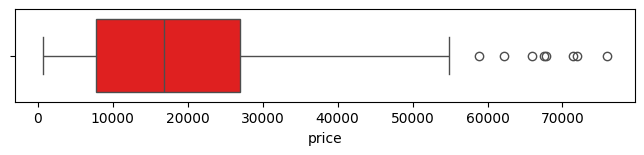

In [264]:
plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=df['price'], color="red")

<Axes: xlabel='mileage'>

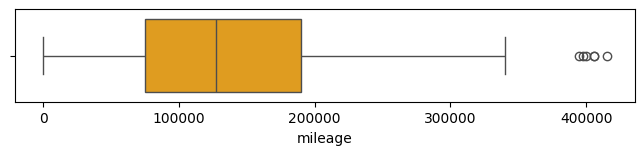

In [265]:
plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=df['mileage'], color="orange")

<Axes: xlabel='ps'>

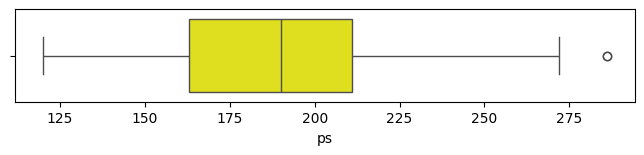

In [266]:
plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=df['ps'], color="yellow")

Histogram

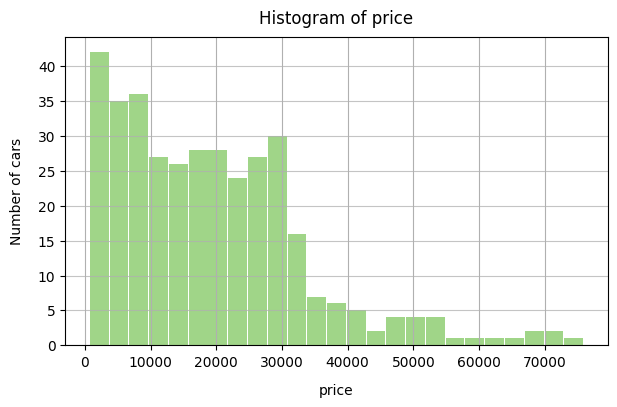

In [267]:
def plot_histogram(variable: str):
    fig = plt.figure( figsize=(7,4))

    plt.xticks(fontsize=14, rotation=0)
    plt.yticks(fontsize=14, rotation=0)

    n, bins, patches = plt.hist(x=df[variable], 
                                bins=25, 
                                color='#42AD12',
                                alpha=0.5, 
                                rwidth=0.95
                    )
    plt.grid(True)
    plt.ticklabel_format(style='plain')
    plt.grid(axis='y', alpha=0.75)

    # Set labels
    plt.xlabel(variable, fontsize=10, labelpad=10)
    plt.ylabel('Number of cars', fontsize=10, labelpad=10)
    plt.title(f'Histogram of {variable}', fontsize=12, pad=10)

    # Set fontsize of tick labels
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)

    plt.show()

plot_histogram('price')

--> distribution is right-skewed

Barchart of cars in the different price categories

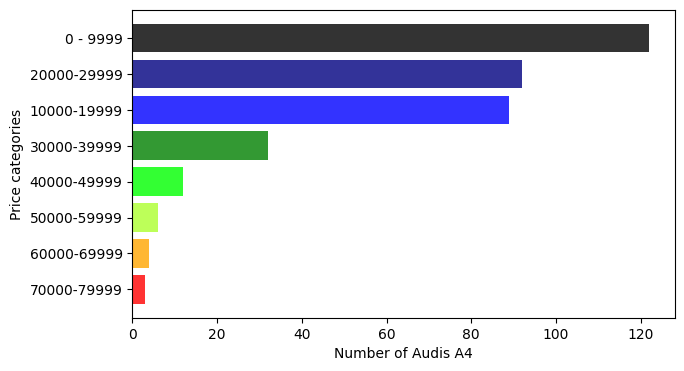

In [268]:
# Group data by rooms (only the topmost 15 values are shown)
df_bar = df['price_cat'].value_counts().nlargest(15).sort_values(ascending=True)

# Values for barchart
napart = list(df_bar.values)
index = list(df_bar.index.values)
y_pos = np.arange(len(index))

# Colors
colors = ['red', 'orange', 'greenyellow', 'lime', 'green', 'blue', 'navy', 'black']

# Figure
fig, ax = plt.subplots(figsize=(7, 4))
bars = ax.barh(y_pos, napart, align='center', color=colors[:len(napart)], alpha=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(index)
ax.set_xlabel('Number of Audis A4', fontsize=10)
ax.set_ylabel('Price categories', fontsize=10)

# Show graph
plt.show()

Mean of prices distributed to the ps-categories

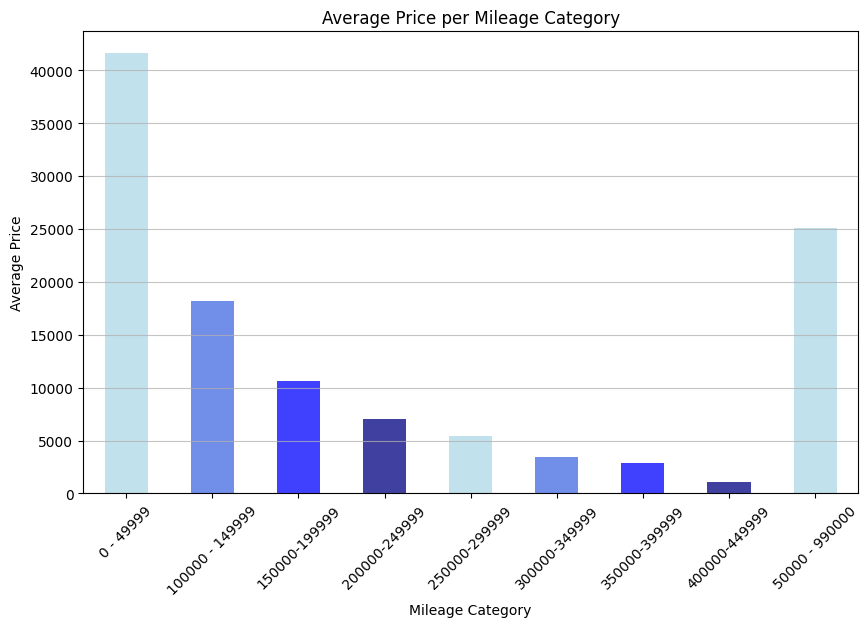

In [269]:
# Calculate the average price per ps_cat
avg_price_per_ps_cat = df.groupby('mileage_cat')['price'].mean()

# Colors
colors = ['lightblue', 'royalblue', 'blue', 'navy']

bars = ax.barh(y_pos, napart, align='center', color=colors[:len(napart)], alpha=0.8)

# create a histogramm
plt.figure(figsize=(10, 6))
avg_price_per_ps_cat.plot(kind='bar', color=colors[:len(napart)], alpha=0.75)
plt.xlabel('Mileage Category')
plt.ylabel('Average Price')
plt.title('Average Price per Mileage Category')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()

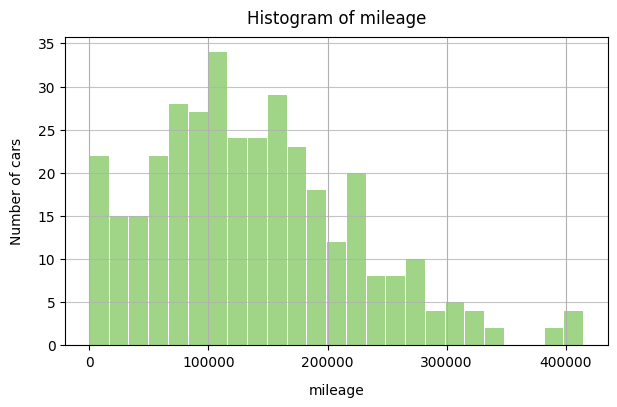

In [270]:
plot_histogram('mileage')

--> distribution is multimodal

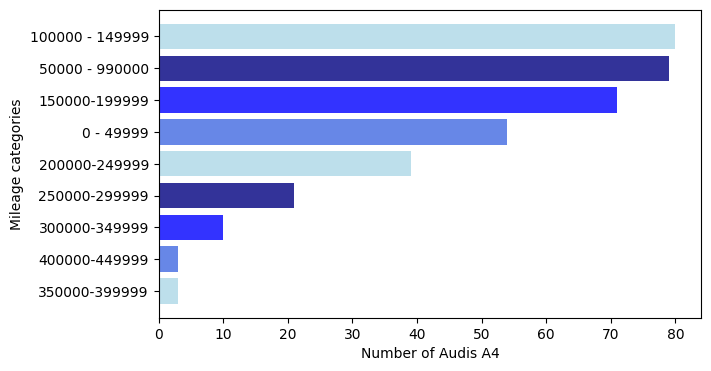

In [271]:
# Group data by rooms (only the topmost 15 values are shown)
df_bar = df['mileage_cat'].value_counts().nlargest(15).sort_values(ascending=True)

# Values for barchart
napart = list(df_bar.values)
index = list(df_bar.index.values)
y_pos = np.arange(len(index))

# Colors
colors = ['lightblue', 'royalblue', 'blue', 'navy']

# Figure
fig, ax = plt.subplots(figsize=(7, 4))
bars = ax.barh(y_pos, napart, align='center', color=colors[:len(napart)], alpha=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(index)
ax.set_xlabel('Number of Audis A4', fontsize=10)
ax.set_ylabel('Mileage categories', fontsize=10)

# Show graph
plt.show()

Text(0.5, 1.0, 'Cars per mileage category')

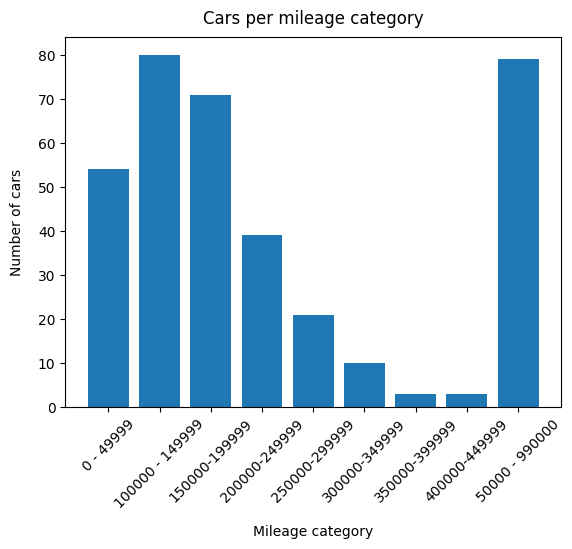

In [272]:
binned_mileage = df.groupby("mileage_cat").size()
plt.bar(binned_mileage.index, binned_mileage.values)
plt.xticks(rotation=45)
plt.xlabel('Mileage category', fontsize=10, labelpad=10)
plt.ylabel('Number of cars', fontsize=10, labelpad=10)
plt.title(f'Cars per mileage category', fontsize=12, pad=10)

Density plot (seaborn)

In [273]:
def distplot(variable: str):
    plt.figure(figsize=(7,4))
    sns.distplot(df[variable], 
                hist=True, 
                kde=True, 
                bins=20, 
                color = 'green',
                hist_kws={'edgecolor':'black'},
                kde_kws={'linewidth': 2},
                )
    plt.title(f'Density plot {variable}', fontsize=12, pad=10)
    plt.xlabel(variable, fontsize=12, labelpad=10)
    plt.ylabel('Density', fontsize=12, labelpad=10)
    plt.grid(True)
    plt.show()

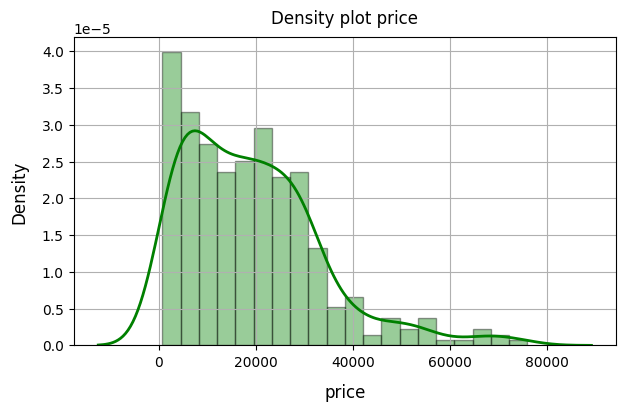

In [274]:
distplot('price')
# Spline interpolation does not work with values < 0

In [275]:
def distplot(variable: str):
    plt.figure(figsize=(7,4))
    sns.distplot(df[variable], 
                hist=True, 
                kde=True, 
                bins=20, 
                color = 'navy',
                hist_kws={'edgecolor':'black'},
                kde_kws={'linewidth': 2},
                )
    plt.title(f'Density plot {variable}', fontsize=12, pad=10)
    plt.xlabel(variable, fontsize=12, labelpad=10)
    plt.ylabel('Density', fontsize=12, labelpad=10)
    plt.grid(True)
    plt.show()

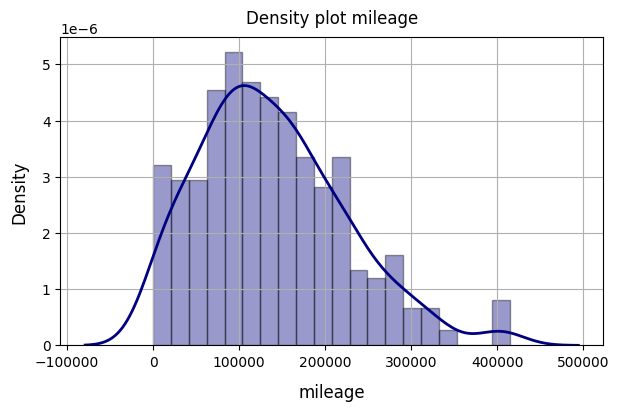

In [276]:
distplot('mileage')
# Spline interpolation does not work with values < 0

Quantile-Quantile-plot

     price       var
33     700 -1.287861
16     890 -1.274546
40     999 -1.266907
187   1100 -1.259828
24    1250 -1.249316
..     ...       ...
312  67570  3.398544
298  67800  3.414663
358  71400  3.666959
313  71930  3.704103
119  75900  3.982330

[360 rows x 2 columns]


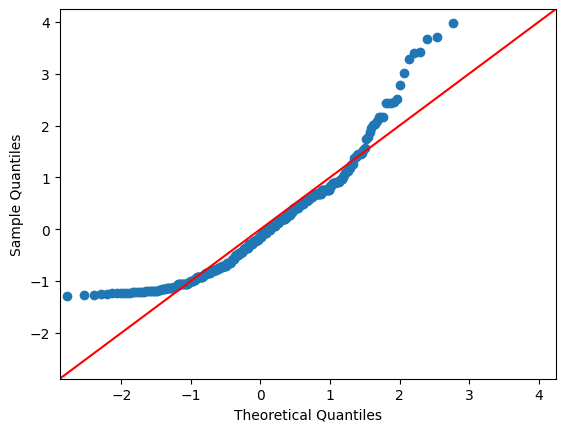

In [277]:
# Variable (standardized)
x = 'price'
df_qq = df
df_qq['var'] = (df[x]-df[x].mean()) / df[x].std()
print(df_qq.sort_values('var')[['price', 'var']])
    
# Plot
sm.qqplot(df_qq['var'], line ='45')
py.show()

--> the data is not normally distributed, there are some outliers

Piechart of price-categories

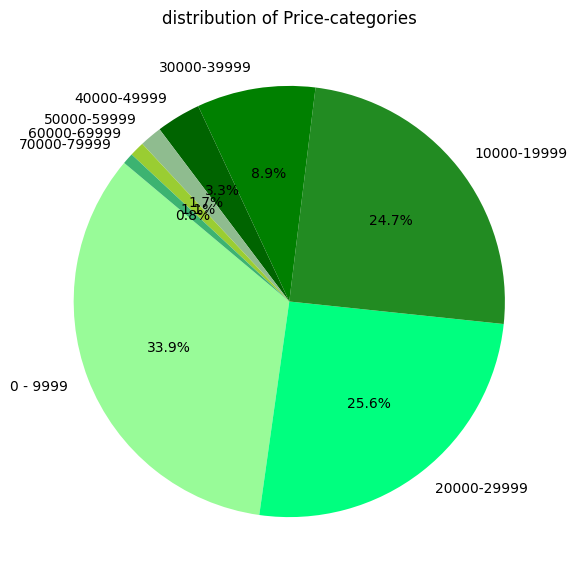

In [278]:

# Group data by ps categories
df_pie = df['price_cat'].value_counts()

# Werte für das Tortendiagramm
sizes = df_pie.values
labels = df_pie.index

# Farben für das Tortendiagramm
colors = ['palegreen', 'springgreen', 'forestgreen', 'green', 'darkgreen', 'darkseagreen', 'yellowgreen', 'mediumseagreen']

# Erstelle das Tortendiagramm
fig, ax = plt.subplots(figsize=(7, 7))
ax.pie(sizes, labels=labels, colors=colors[:len(sizes)], autopct='%1.1f%%', startangle=140)

# Füge Titel hinzu
ax.set_title('distribution of Price-categories')

# Zeige das Tortendiagramm
plt.show()



piechart of ps-categories

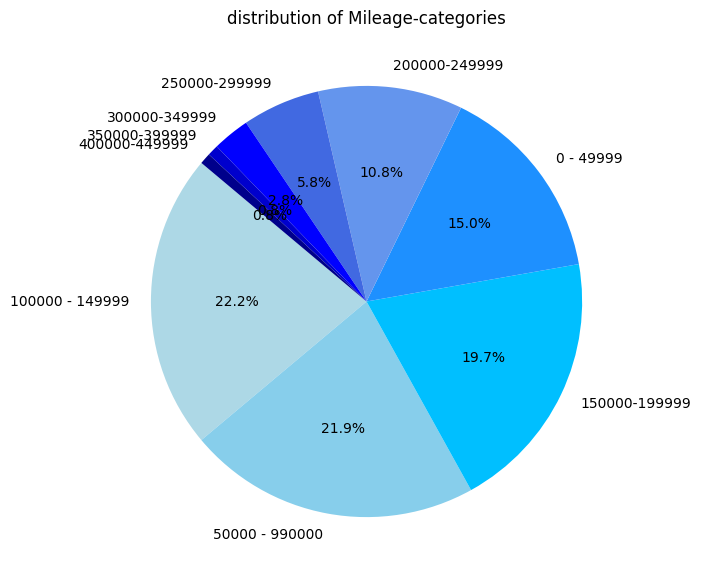

In [279]:
# Group data by ps categories
df_pie = df['mileage_cat'].value_counts()

# Werte für das Tortendiagramm
sizes = df_pie.values
labels = df_pie.index

# Farben für das Tortendiagramm
colors = ['lightblue', 'skyblue', 'deepskyblue', 'dodgerblue', 'cornflowerblue', 'royalblue', 'blue', 'mediumblue', 'darkblue', 'navy', 'midnightblue']

# Erstelle das Tortendiagramm
fig, ax = plt.subplots(figsize=(7, 7))
ax.pie(sizes, labels=labels, colors=colors[:len(sizes)], autopct='%1.1f%%', startangle=140)

# Füge Titel hinzu
ax.set_title('distribution of Mileage-categories')

# Zeige das Tortendiagramm
plt.show()


### 4.4 Multivariate graphical exploratory data analysis

Creating multiplots with .subplots()

In [280]:
# Get coords for addresses

addresses = df['selleraddress_raw']
addresses.to_csv('./data/addresses.csv')
# Converted via https://www.geoapify.com/tools/geocoding-online/

In [281]:
coordinates = pd.read_csv('./data/coordinates.csv')
df['lat'] = coordinates['lat']
df['lon'] = coordinates['lon']

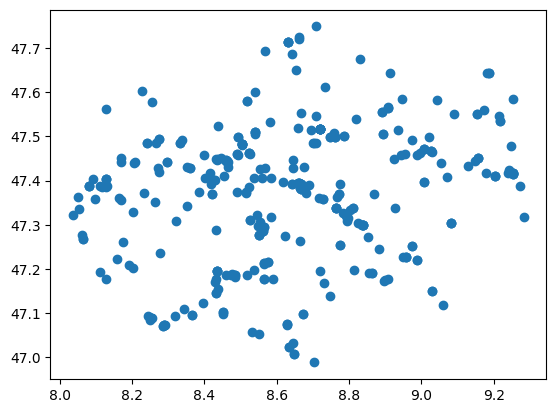

In [282]:
plt.scatter(df['lon'], df['lat'])

In [283]:
# Create a scatter map
fig = px.scatter_mapbox(
    df,
    lat="lat",
    lon="lon",
    text="title_raw",
    mapbox_style="open-street-map",
    zoom=8,
    height=800,
    width=800,
    title="Map of Audi A4 cars for sale in and around canton of Zurich",
)

# Show the map
fig.show()

In [284]:
import folium

# Create a map centered around the average latitude and longitude
map_center = [df['lat'].mean(), df['lon'].mean()]
m = folium.Map(location=map_center, zoom_start=10)

# Add blue markers for each car location
for idx, row in df.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=row['title_raw'],
        icon=folium.Icon(color='blue')
    ).add_to(m)

# Display the map
m

In [285]:
# Mapbox not available
fig = ff.create_hexbin_mapbox(
    data_frame=df, lat="lat", lon="lon",
    nx_hexagon=10, opacity=0.5, labels={"color": "Number of cars"},
    min_count=1, color_continuous_scale="Viridis",
    show_original_data=True,
    original_data_marker=dict(size=4, opacity=0.6, color="deeppink"),
    mapbox_style="white-bg", height=900, width=900
)
fig.show()

Scatterplot-matrix

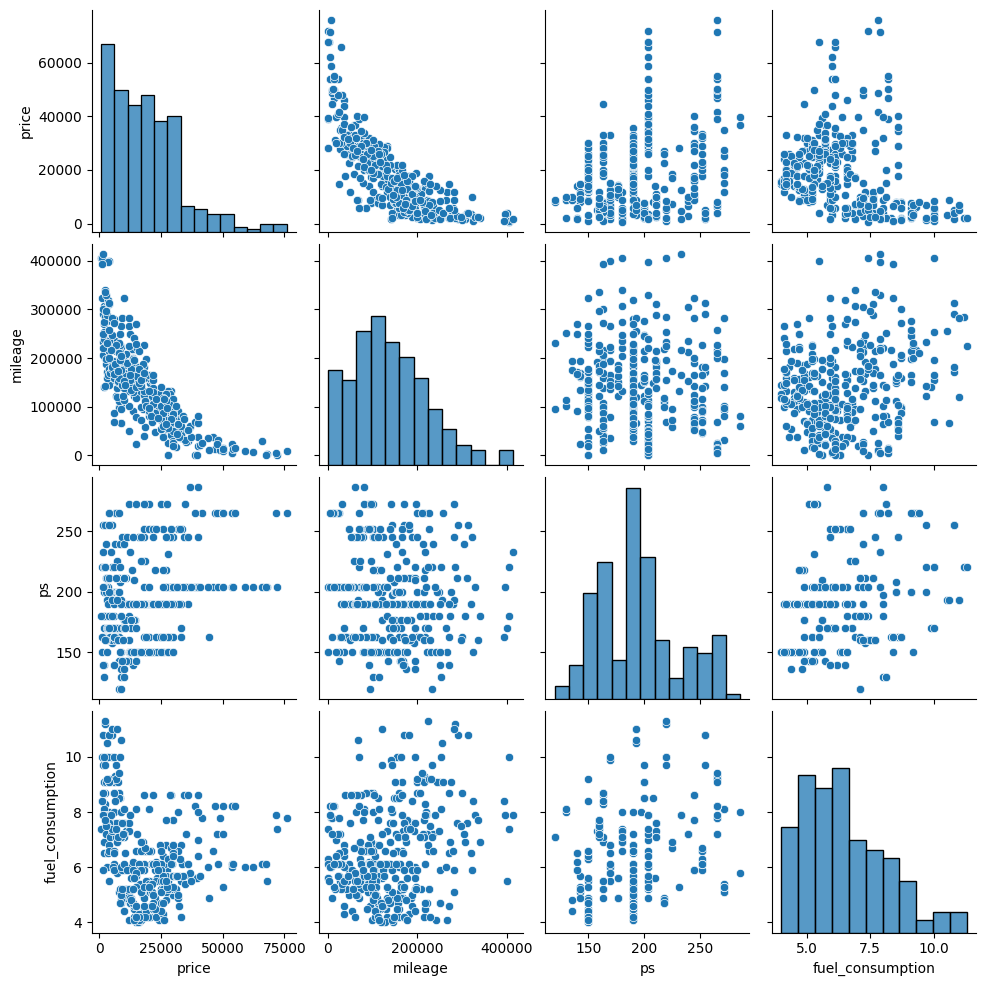

In [286]:
sns.pairplot(df[["price", "mileage", "ps", "fuel_consumption"]])

In [287]:
corr = df[["price", "mileage", "ps", "fuel_consumption"]].corr().round(2)
corr

,price,mileage,ps,fuel_consumption
price,1.00,-0.78,0.29,-0.29
mileage,-0.78,1.00,-0.09,0.26
ps,0.29,-0.09,1.00,0.29
fuel_consumption,-0.29,0.26,0.29,1.00


Correlation heatmap

<Axes: >

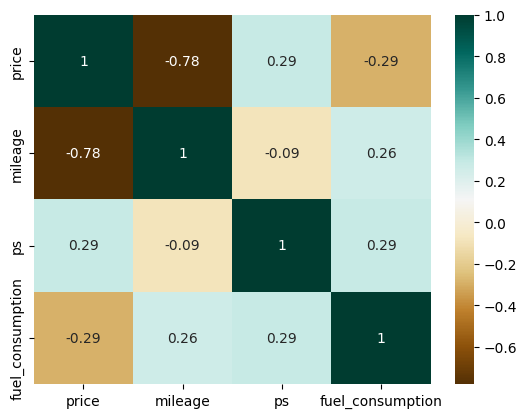

In [288]:
sns.heatmap(corr, cmap="BrBG", annot=True)

In [289]:
df[["price", "mileage", "ps", "fuel_consumption"]].cov()

,price,mileage,ps,fuel_consumption
price,2.036024e+08,-9.513146e+08,151811.333720,-6881.525070
mileage,-9.513146e+08,7.303483e+09,-267051.830084,36569.300000
ps,1.518113e+05,-2.670518e+05,1339.603335,17.501671
fuel_consumption,-6.881525e+03,3.656930e+04,17.501671,2.697939


Scatterplot with regression line

-0.13x + 37088.21


(array([-40000., -20000.,      0.,  20000.,  40000.,  60000.,  80000.,
        100000.]),
 [Text(0, -40000.0, '−40000'),
  Text(0, -20000.0, '−20000'),
  Text(0, 0.0, '0'),
  Text(0, 20000.0, '20000'),
  Text(0, 40000.0, '40000'),
  Text(0, 60000.0, '60000'),
  Text(0, 80000.0, '80000'),
  Text(0, 100000.0, '100000')])

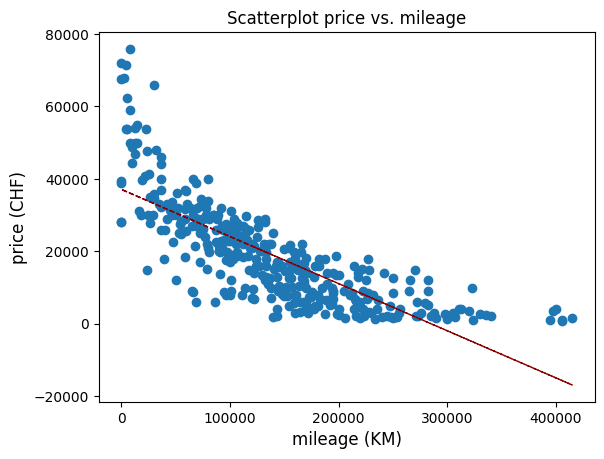

In [290]:
plt.scatter(df['mileage'], df['price'])
b, a = np.polyfit(df['mileage'], df['price'], 1)
plt.plot(df['mileage'], 
         b*df['mileage'] + a, 
         linewidth=1,
         linestyle='dashed',
         color='darkred')
print(f"{b.round(2)}x + {a.round(2)}")

# Add title and axes labels
plt.title('Scatterplot price vs. mileage', fontsize=12)
plt.ylabel('price (CHF)', fontsize=12)
plt.xlabel('mileage (KM)', fontsize=12)

# Set fontsize of tick labels
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

0.0x^2 + -0.29x + 46812.74


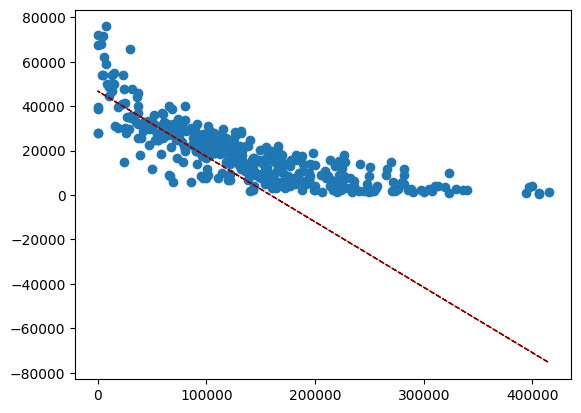

In [291]:
plt.scatter(df['mileage'], df['price'])
c, b, a = np.polyfit(df['mileage'], df['price'], 2)
plt.plot(df['mileage'], 
         df['mileage']**c + b*df['mileage'] + a, 
         linewidth=1,
         linestyle='dashed',
         color='darkred')
print(f"{c.round(2)}x^2 + {b.round(2)}x + {a.round(2)}")

Pearson correlation price vs. PS

In [292]:
from scipy.stats import pearsonr

# Berechne den Pearson-Korrelationskoeffizienten und den p-Wert
res = pearsonr(df['price'], df['mileage'])

print(f'Persons correlation coefficient (r): {res[0]:.4f}')
print(f'p-value: {res[1]:.4f}')

Persons correlation coefficient (r): -0.7801
p-value: 0.0000


In [293]:
from scipy.stats import pearsonr

# Berechne den Pearson-Korrelationskoeffizienten und den p-Wert
res = pearsonr(df['price'], df['ps'])

print(f'Persons correlation coefficient (r): {res[0]:.4f}')
print(f'p-value: {res[1]:.4f}')

Persons correlation coefficient (r): 0.2907
p-value: 0.0000


Scatterplot

113.33x + -3033.1


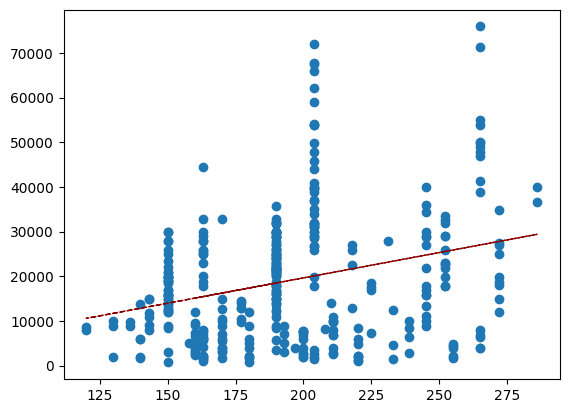

In [294]:
plt.scatter(df['ps'], df['price'])
b, a = np.polyfit(df['ps'], df['price'], 1)
plt.plot(df['ps'], 
         b*df['ps'] + a, 
         linewidth=1,
         linestyle='dashed',
         color='darkred')
print(f"{b.round(2)}x + {a.round(2)}")

Bubble plot

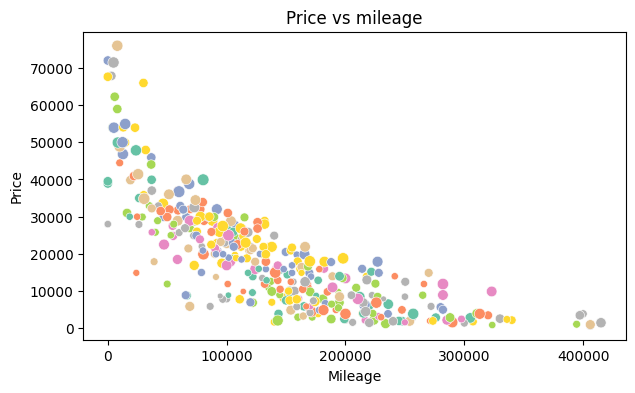

In [295]:
plt.figure(figsize=(7,4))
plt.ticklabel_format(style='plain')
cmap = sns.cubehelix_palette(dark=.3, light=3, as_cmap=True)

ax = sns.scatterplot(x="mileage", 
                     y="price",
                     size="ps", # determines bubble size
                     hue="fuel_consumption",  # determines color
                     palette="Set2",
                     data=df)

# Set title and axes
ax.set_title('Price vs mileage', fontsize = 12)
ax.set_xlabel('Mileage', fontsize = 10)
ax.set_ylabel('Price', fontsize = 10)
ax.legend([],[], frameon=False) # skip legend

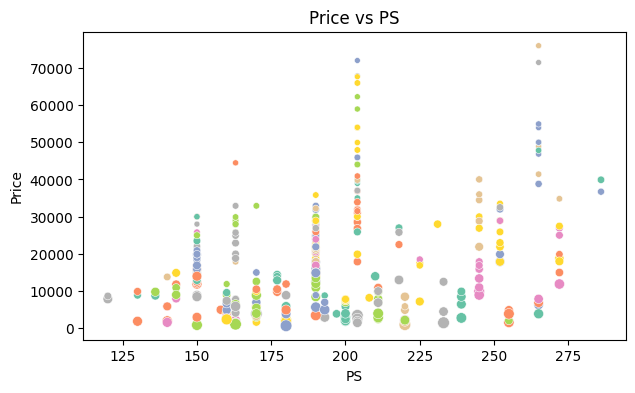

In [296]:
plt.figure(figsize=(7,4))
plt.ticklabel_format(style='plain')
cmap = sns.cubehelix_palette(dark=.3, light=3, as_cmap=True)

ax = sns.scatterplot(x="ps", 
                     y="price",
                     size="mileage", # determines bubble size
                     hue="fuel_consumption",  # determines color
                     palette="Set2",
                     data=df)

# Set title and axes
ax.set_title('Price vs PS', fontsize = 12)
ax.set_xlabel('PS', fontsize = 10)
ax.set_ylabel('Price', fontsize = 10)
ax.legend([],[], frameon=False) # skip legend

Hexagonal binning plot

(360, 21)


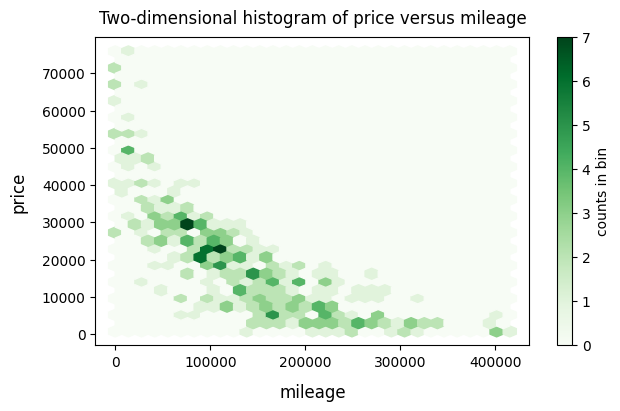

In [297]:
# Subset
df_sub = df.loc[(df.price <= 80000) & (df.mileage <= 450000)]
print(df_sub.shape)

# Plot
fig = plt.figure( figsize=(7,4) )
plt.hexbin(df_sub.mileage, df_sub.price, gridsize=30, cmap='Greens')

# Set labels
plt.xlabel('mileage', fontsize=12, labelpad=10)
plt.ylabel('price', fontsize=12, labelpad=10)
plt.title('Two-dimensional histogram of price versus mileage', fontsize=12, pad=10)

cb = plt.colorbar(label='count in bin')
cb.set_label('counts in bin')

In [298]:
df["mileage"]

0      136000
1       79116
2      100000
3      218000
4      107000
        ...  
355     44500
356    133000
357     65000
358      4800
359    121700
Name: mileage, Length: 360, dtype: int64

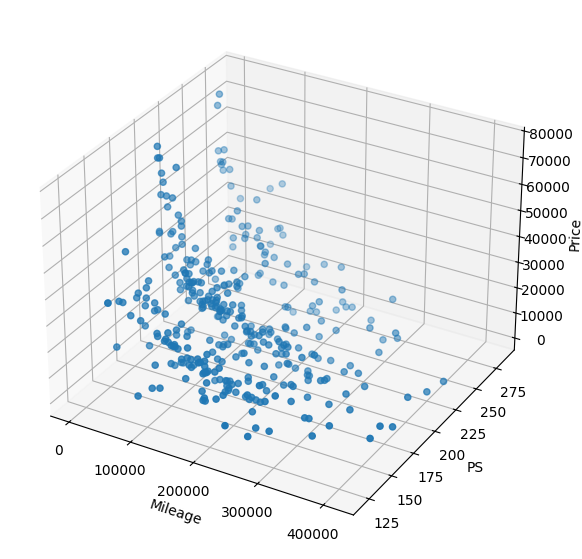

In [299]:
# Price in dependence of two variables: mileage and ps
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection='3d')


ax.scatter(df["mileage"], df["ps"], df["price"], marker="o")

ax.set_xlabel('Mileage')
ax.set_ylabel('PS')
ax.set_zlabel('Price')

plt.show()

### 4.5 ANOVA

Grouped boxplot

<Axes: xlabel='price', ylabel='drive_raw'>

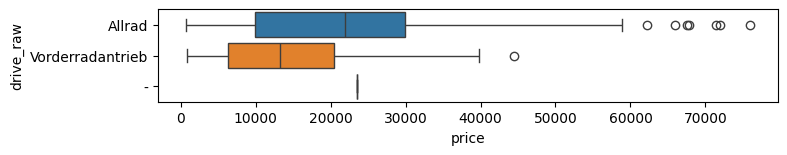

In [300]:
plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(data=df, x="price", y="drive_raw", hue="drive_raw")

Analysis of variance (ANOVA)

In [301]:
# Create subsets (groups)
allwheel = df.loc[df['drive_raw'] == 'Allrad']
frontwheel = df.loc[df['drive_raw'] == 'Vorderradantrieb']

# Create ANOVA
fvalue, pvalue = stats.f_oneway(allwheel['price'],
                                frontwheel['price'])

# Print results
print('F-value:', fvalue.round(3), 'p-value', pvalue.round(4))

F-value: 34.394 p-value 0.0



Definition of a null and an alternative hypothesis and choice a significance level:

- Null hypothesis: there is no difference in the price between the different drive types (allwheel or frontwheel). 
- Alternative hypothesis: there is a difference in the price between the different drive types (allwheel or frontwheel). 
- Significance level of 5% (0.05). 


Interpretation:

Because the p-value is lower than 0.05, the null hypothesis can be rejected, i.e. there is evidence that the used car prices of allwheel drive and frontwheel drive differ. Note that, from the ANOVA, it is not clear which groups show differences of prices.

Unpaired two-sample t-test

In [302]:
# Create subsets (groups)
allwheel = df.loc[df['drive_raw'] == 'Allrad']
frontwheel = df.loc[df['drive_raw'] == 'Vorderradantrieb']

# Create t-test
result = stats.ttest_ind(allwheel['price'], frontwheel['price'])

# Print result
print('Test-statistic:', result[0].round(5), 'p-value',  result[1].round(5))

Test-statistic: 5.86461 p-value 0.0


Interpretation

Because the p-value is lower than 0.05, the null hypothesis can be rejected, i.e. there is evidence that the used car prices of allwheel drive and frontwheel drive differ. Note that, from the t-test above, it is not clear which drive show higher or lower prices. It only shows that there is a statistically significant (5% significance level) difference between prices.

### 5. Modeling Method

### 5.1 Simple linear regression

In [303]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(df['mileage'], 
                                                    df['price'], 
                                                    test_size=0.20, 
                                                    random_state=42)
# Show X_train
print('X_train:')
print(X_train.head(), '\n')

# Show y_train
print('y_train:')
print(y_train.head())

X_train:
289    166000
336     73750
231    257000
75     159000
194    157000
Name: mileage, dtype: int64 

y_train:
289    12500
336    34444
231     3900
75      5800
194     9999
Name: price, dtype: int64


In [304]:
# Fit the regression model
slope, intercept, r, p, std_err = stats.linregress(X_train, y_train)

# Print results of the regression model
print('Linear regression result:')
print(f'Intercept with y-axis (alpha):            {intercept:.2f}')
print(f'Slope of regression line (beta):          {slope:.3f}')
print(f'p-value:                                  {p:.4f}')
print(f'R-squared (coefficient of determination): {r**2:.4f}')

Linear regression result:
Intercept with y-axis (alpha):            37050.86
Slope of regression line (beta):          -0.131
p-value:                                  0.0000
R-squared (coefficient of determination): 0.6268


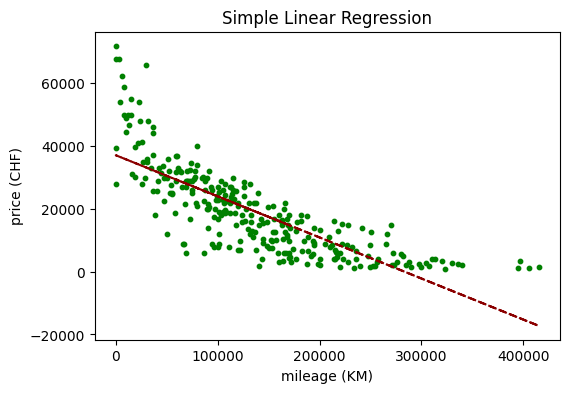

In [310]:
# Function to calculate model predictions
def myfunc(x):
    return slope * x + intercept

# Apply myfunc() to x, i.e. make predictions 
mymodel = pd.Series(map(myfunc, X_train))

# Scatterplot with regression line
plt.figure(figsize=(6,4))
plt.scatter(X_train, y_train, s=10, color='green')
plt.plot(X_train, mymodel, color='darkred', linestyle='dashed')
plt.title('Simple Linear Regression')
plt.xlabel('mileage (KM)')
plt.ylabel('price (CHF)')

plt.show()

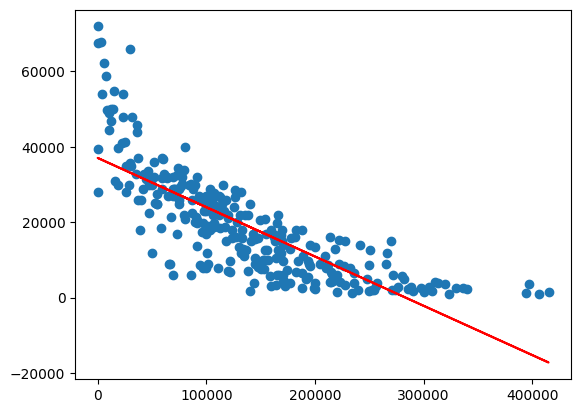

In [305]:
# Function to calculate model predictions
def linreg(x):
    return slope * x + intercept

# Apply linreg() to x, i.e. make predictions 
y_pred = pd.Series(map(linreg, X_train))
plt.scatter(X_train, y_train)
plt.plot(X_train, y_pred, color='red')

In [311]:
residuals = y_train - y_pred

# Check the first residual value in our data set
print(f'1st Predicted price in dataset: {y_pred[0]:.2f}')
print(f'1st Observed price in dataset: {y_train[0]:.2f}')
print(f'1st Residual price in dataset: {residuals[0]:.2f}')

1st Predicted price in dataset: 15335.15
1st Observed price in dataset: 21999.00
1st Residual price in dataset: 6663.85


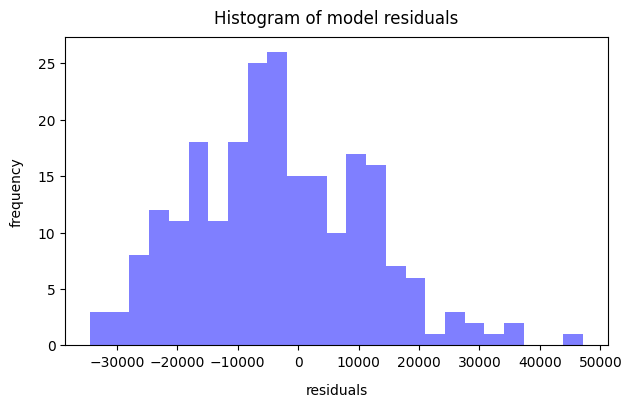

In [307]:
# Plot histogram of residuals
fig = plt.figure( figsize=(7,4))
n, bins, patches = plt.hist(x=residuals, 
                            bins=25, 
                            color='blue',
                            alpha=0.5
                   )

# Set title and labels
plt.xlabel('residuals', fontsize=10, labelpad=10)
plt.ylabel('frequency', fontsize=10, labelpad=10)
plt.title('Histogram of model residuals', fontsize=12, pad=10)

# Show plot
plt.show()

Compare observed prices and predicted prices

In [312]:
# Create model predictions for test data
predicted = myfunc(X_test)
predicted.round(1)

# Compare the observed prices with the predicted prices
for i in range(0,10):
    print(f'Observed price: {y_test.iloc[i]:.1f}, Predicted price: {predicted.iloc[i]:.1f}')

Observed price: 11999.0, Predicted price: 7590.8
Observed price: 14400.0, Predicted price: 17297.4
Observed price: 27990.0, Predicted price: 29790.5
Observed price: 24900.0, Predicted price: 27605.8
Observed price: 17900.0, Predicted price: 7355.3
Observed price: 2990.0, Predicted price: 6962.8
Observed price: 2200.0, Predicted price: 8729.4
Observed price: 1999.0, Predicted price: 5000.6
Observed price: 29980.0, Predicted price: 33824.0
Observed price: 15900.0, Predicted price: 18432.6


In [210]:
# Analysis using statsmodels (but still linear regression)
res = sm.OLS(y_train, sm.add_constant(X_train.to_list())).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     480.3
Date:                Sun, 05 Jan 2025   Prob (F-statistic):           3.67e-63
Time:                        17:07:37   Log-Likelihood:                -3017.4
No. Observations:                 288   AIC:                             6039.
Df Residuals:                     286   BIC:                             6046.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.705e+04    966.226     38.346      0.0

### 5.2 Multiple linear regression

In [212]:
# Create train and test samples (we name it X2_ and y_2 because we already used X_ and y_ above)
X2_train, X2_test, y2_train, y2_test = train_test_split(df[['mileage',
                                                            'ps',
                                                            'fuel_consumption']], 
                                                        df['price'], 
                                                        test_size=0.20, 
                                                        random_state=42)

# Show X2_train
print('X2_train:')
print(X2_train.head(), '\n')

# Show y2_train
print('y2_train:')
print(y2_train.head())

X2_train:
     mileage   ps  fuel_consumption
289   166000  233               7.9
336    73750  245               8.6
231   257000  265               9.1
75    159000  163               8.7
194   157000  211               7.1 

y2_train:
289    12500
336    34444
231     3900
75      5800
194     9999
Name: price, dtype: int64


In [213]:
# Add constant to the model
X2_train_const = sm.add_constant(X2_train)

# Create the multiple regression model
olsmod = sm.OLS(y_train, X2_train_const)
olsres = olsmod.fit()

# Print full model output
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     217.7
Date:                Sun, 05 Jan 2025   Prob (F-statistic):           2.64e-73
Time:                        17:07:58   Log-Likelihood:                -2987.4
No. Observations:                 288   AIC:                             5983.
Df Residuals:                     284   BIC:                             5997.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2.563e+04   2891.253  

Interpretation:

- R-squared:
This is the coefficient of determination. A value of 0.697 means, that the explanatory variables explain 69% of the variaton of our target variable (audi a4 prices) - that is quite good.

- coef:
These are the estimated coefficients of the explanatory variables ('slopes of the regression line' of each variable). These are nedded for the price predictions in our model.

- P>|t|:
These are the p-values. If < 0.05, the explanatory variables shows a statistically siginificant (5% significance level) contribution in explaining the target variable. All variables are significant here.

### 5.3 Regression Tree

In [214]:
# Create train and test samples
X3_train, X3_test, y3_train, y3_test = train_test_split(df[['mileage', 
                                                        'ps',
                                                        'fuel_consumption']], 
                                                        df['price'], 
                                                        test_size=0.20, 
                                                        random_state=42)

# Show X3_train
print('X3_train:')
print(X3_train.head(), '\n')

# Show y3_train
print('y3_train:')
print(y3_train.head())

X3_train:
     mileage   ps  fuel_consumption
289   166000  233               7.9
336    73750  245               8.6
231   257000  265               9.1
75    159000  163               8.7
194   157000  211               7.1 

y3_train:
289    12500
336    34444
231     3900
75      5800
194     9999
Name: price, dtype: int64


In [215]:
# Create decision tree regressor object
reg = DecisionTreeRegressor(random_state=20, max_depth=5)

# Train decision tree regressor
reg = reg.fit(X3_train, y3_train)

# Predict the response for test dataset
y_pred = reg.predict(X3_test)

In [216]:
# Calculate coefficient of determination
print('R-squared:', r2_score(y3_test, y_pred))

R-squared: 0.8421745663007119


In [217]:
from sklearn.tree import export_text

# Print the text representation of the decision tree
tree_text = export_text(reg, feature_names=['mileage', 'ps', 'fuel_consumption'])
print(tree_text)

|--- mileage <= 85812.50
|   |--- mileage <= 36800.00
|   |   |--- ps <= 197.00
|   |   |   |--- fuel_consumption <= 5.05
|   |   |   |   |--- value: [44444.00]
|   |   |   |--- fuel_consumption >  5.05
|   |   |   |   |--- mileage <= 29600.50
|   |   |   |   |   |--- value: [28942.50]
|   |   |   |   |--- mileage >  29600.50
|   |   |   |   |   |--- value: [34350.00]
|   |   |--- ps >  197.00
|   |   |   |--- mileage <= 8200.00
|   |   |   |   |--- mileage <= 15.00
|   |   |   |   |   |--- value: [39500.00]
|   |   |   |   |--- mileage >  15.00
|   |   |   |   |   |--- value: [63716.67]
|   |   |   |--- mileage >  8200.00
|   |   |   |   |--- fuel_consumption <= 5.85
|   |   |   |   |   |--- value: [39145.00]
|   |   |   |   |--- fuel_consumption >  5.85
|   |   |   |   |   |--- value: [47998.36]
|   |--- mileage >  36800.00
|   |   |--- fuel_consumption <= 9.30
|   |   |   |--- ps <= 197.00
|   |   |   |   |--- ps <= 161.50
|   |   |   |   |   |--- value: [21116.00]
|   |   |   |   |

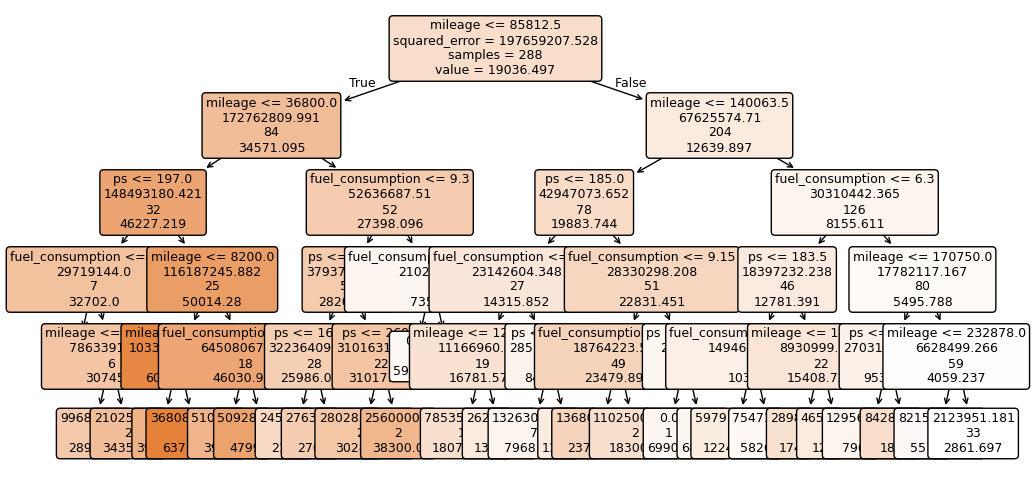

In [ ]:
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plot_tree(reg, feature_names=['mileage', 'ps', 'fuel_consumption'], class_names=['price'], filled=True, fontsize=9, label='root', rounded=True)
plt.show()

### 6. Model evaluation

6.1 Model evaluation using suitable measures of fit (e.g. r-squared, rmse)
- Vorlesungunterlagen SWxxx, Slide XXX
- - Exercises SW7, Task 1-2


6. Modellevaluation (z. B. R-Quadrat, RMSE):
Zu finden in Woche 07, Aufgabe 1 (b, c):
- Evaluation der Modelle mithilfe von R-Quadrat und Residuen.


### 7. Interpretation

7.1 Correct interpretation of model results and measures of fit
- Vorlesungunterlagen SWxxx, Slide XXX
- Exercises SW7, Task 2


7. Korrekte Interpretation von Modellergebnissen und Gütemaßen:
Zu finden in Woche 07, Aufgaben 1 und 2:
- Interpretation der Ergebnisse in den Bereichen lineare Regression und Random Forest.


8. Bereitstellung der Materialien in Jupyter-Notebooks:
In allen Wochen enthalten:
- Jede Aufgabe verlangt die Einreichung von Jupyter-Notebooks als `.html`-Dateien mit
entsprechenden Erklärungen.

1. Kreativität der Umsetzung:
- Hängt davon ab, wie einzigartig und innovativ du die Aufgaben kombinierst und erweiterst.
2. Verwendung von MySQL- oder PostgreSQL-Datenbanken:
Zu finden in Woche 02, Aufgabe 4:
- Standardmäßig wird SQLite verwendet, die Anpassung auf MySQL/PostgreSQL könnte jedoch
Kreativität zeigen.
3. Integration und Visualisierung geografischer Daten:
Zu finden in Woche 05, Aufgaben 1 und 3:
- GIS-Funktionen und Analyse nächster Nachbarn.
4. Verwendung des Chi-Quadrat-Tests oder ANOVA:
Zu finden in Woche 06, Aufgaben 3 und 4:
- Aufgaben mit Fokus auf einseitige Varianzanalyse (ANOVA) und Chi-Quadrat-Tests.
5. Verwendung von mehr als einem Modell für Vorhersagen:
Zu finden in Woche 07, Aufgaben 1 und 2:
- Einsatz von mehreren Modellen wie linearer Regression und Random Forest.
Projektpräsentation in Videoform (Maximal 3 Punkte):
Die Präsentation sollte den Inhalt und die Struktur der oben genannten Aufgaben klar und
überzeugend darstellen.

In [684]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.5.0-1025-azure
Datetime: 2024-12-31 15:15:31
Python Version: 3.11.10
-----------------------------------
